# ML - Group 2 - Workgroup Project: ACME Solar Prediction
## MBDS April 2025 - IE University

## Dataset Documentation
- **solar_dataset.csv**: contains `Date` and 98 station target columns (e.g., ACME, ADAX, ...), which show the energy production at that station
- **additional_variables.csv**: additional daily NWP features keyed by `Date`
- **station_info.csv**: station metadata (`stid`, `nlat`, `elon`, `elev`) --> not used in the model

**Target:** `ACME` daily solar energy.  
**Goal:** Predict ACME for 2008-01-01 → 2012-11-30.

## 0. Imports & paths

In [1]:
from __future__ import annotations
import os, sys, math, json, textwrap
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.rcParams["figure.dpi"] = 130
plt.rcParams["figure.figsize"] = (8, 4.5)

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor as model
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import TimeSeriesSplit, ParameterSampler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline as SkPipe
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import randint, uniform

# Paths
DATA_DIR = Path("./data")
FIG_DIR  = Path("./figures"); FIG_DIR.mkdir(exist_ok=True, parents=True)
ART_DIR  = Path("./artifacts"); ART_DIR.mkdir(exist_ok=True, parents=True)

CSV_MAIN = DATA_DIR / "solar_dataset.csv"           
CSV_ADD  = DATA_DIR / "additional_variables.csv"    
CSV_INFO = DATA_DIR / "station_info.csv"            

DATE_COL = "Date"
TRAIN_END = pd.Timestamp("2007-12-31")  
TEST_START = pd.Timestamp("2008-01-01") 

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


## Auxiliary functions

In [2]:
def safe_mape(y_true, y_pred, eps=1.0):
    """MAPE (%) robust to zeros: denominator is max(|y|, eps)."""
    y_true = np.asarray(y_true).astype(float)
    y_pred = np.asarray(y_pred).astype(float)
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100.0

def calculate_feature_importance_regression(X, y, model, original_data=None, pca_object=None):
    """
    Calculate feature importance for regression models
    """
    if pca_object is not None and original_data is not None:
        # If PCA was applied, map back to original features
        # PCA loadings show how much each original feature contributes to each PC
        loadings = np.abs(pca_object.components_)  # shape: (n_components, n_features)

        # Model coefficients for each PC
        model_coefs = np.abs(model.coef_)  # shape: (n_components,)

        # Weight each loading by the corresponding PC coefficient
        # This tells us how much each original feature influences the prediction
        # through all the PCs
        feature_importance = np.zeros(loadings.shape[1])
        for i in range(len(model_coefs)):
            feature_importance += loadings[i] * model_coefs[i]

        feature_names = original_data.columns

        print(f"✓ Variable importance calculated from PCA loadings and model coefficients ({pca_object.n_components_} components)")
    else:
        # Direct feature importance from model coefficients
        feature_importance = np.abs(model.coef_)
        feature_names = X.columns

        print(f"✓ Variable importance calculated from model coefficients")

    # Create importance dataframe
    importance_df = pd.DataFrame({
        'Variable': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    # IMPORTANTE: Asegurarse de retornar el dataframe
    return importance_df

def plot_feature_importance(importance_df, title='Feature Importance'):
    """Plot feature importance"""
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Variable'], importance_df['Importance'])
    plt.xlabel('Importance Score (|coefficient|)')
    plt.ylabel('Variable')
    plt.title(title)
    plt.gca().invert_yaxis()  # Para que la variable más importante esté arriba
    plt.tight_layout()
    plt.show()
    return importance_df

def preprocess_data(df, numerical_vars, categorical_vars, scaling_type="min-max",
                   encoding_type="ordinal", use_pca=False, pca_variance=0.9,
                   fill_numerical_na="mean", fill_categorical_na="mode",
                   fitted_imputer=None, fitted_scaler=None, fitted_encoder=None, fitted_pca=None):
    """
    Preprocess data according to the specified parameters
    Returns: processed_df, imputer, scaler, encoder, pca_object
    """
    df_prep = df.copy()

    # Separate numerical and categorical data
    df_numerical = df_prep[numerical_vars] if numerical_vars else pd.DataFrame()
    df_categorical = df_prep[categorical_vars] if categorical_vars else pd.DataFrame()

    processed_dfs = []

    # Handle missing values in numerical variables
    if not df_numerical.empty and fill_numerical_na != "none":
        if fitted_imputer is None:
            # Training: fit the imputer
            if fill_numerical_na == "mean":
                df_numerical = df_numerical.fillna(df_numerical.mean())
                print("✓ Filled numerical missing values with mean")
            elif fill_numerical_na == "median":
                df_numerical = df_numerical.fillna(df_numerical.median())
                print("✓ Filled numerical missing values with median")
            elif fill_numerical_na == "model":
                fitted_imputer = IterativeImputer(model(), random_state=42)
                df_numerical = pd.DataFrame(
                    fitted_imputer.fit_transform(df_numerical),
                    columns=df_numerical.columns,
                    index=df_numerical.index
                )
                print("✓ Filled numerical missing values using IterativeImputer")
        else:
            # Val/Test: use fitted imputer
            if fill_numerical_na == "model":
                df_numerical = pd.DataFrame(
                    fitted_imputer.transform(df_numerical),
                    columns=df_numerical.columns,
                    index=df_numerical.index
                )

    # Handle missing values in categorical variables
    if not df_categorical.empty and fill_categorical_na != "none":
        if fill_categorical_na == "mode":
            for col in df_categorical.columns:
                mode_value = df_categorical[col].mode()
                if len(mode_value) > 0:
                    df_categorical[col] = df_categorical[col].fillna(mode_value[0])
            print("✓ Filled categorical missing values with mode")
        elif fill_categorical_na == "missing":
            for col in df_categorical.columns:
                df_categorical[col] = df_categorical[col].cat.add_categories(['missing'])
                df_categorical[col] = df_categorical[col].fillna('missing')
            print("✓ Filled categorical missing values with 'missing' category")

    # Process numerical variables
    if not df_numerical.empty:
        if fitted_scaler is None:
            # Training: fit the scaler
            if scaling_type == "min-max":
                fitted_scaler = MinMaxScaler()
                df_numerical_scaled = pd.DataFrame(
                    fitted_scaler.fit_transform(df_numerical),
                    columns=df_numerical.columns,
                    index=df_numerical.index
                )
                print("✓ Applied MinMax scaling to numerical variables")
            elif scaling_type == "standard":
                fitted_scaler = StandardScaler()
                df_numerical_scaled = pd.DataFrame(
                    fitted_scaler.fit_transform(df_numerical),
                    columns=df_numerical.columns,
                    index=df_numerical.index
                )
                print("✓ Applied Standard scaling to numerical variables")
            else:
                df_numerical_scaled = df_numerical
                print("✓ No scaling applied to numerical variables")
        else:
            # Val/Test: use fitted scaler
            df_numerical_scaled = pd.DataFrame(
                fitted_scaler.transform(df_numerical),
                columns=df_numerical.columns,
                index=df_numerical.index
            )

        processed_dfs.append(df_numerical_scaled)

    # Process categorical variables
    if not df_categorical.empty:
        if fitted_encoder is None:
            # Training: fit the encoder
            if encoding_type == "ordinal":
                df_categorical_str = df_categorical.astype(str)
                fitted_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
                df_categorical_encoded = pd.DataFrame(
                    fitted_encoder.fit_transform(df_categorical_str),
                    columns=df_categorical.columns,
                    index=df_categorical.index
                )
                print("✓ Applied Ordinal encoding to categorical variables")
            elif encoding_type == "one-hot":
                df_categorical_str = df_categorical.astype(str)
                df_categorical_encoded = pd.get_dummies(df_categorical_str, prefix_sep='_')
                fitted_encoder = df_categorical_encoded.columns  # Save column names
                print("✓ Applied One-Hot encoding to categorical variables")
            else:
                df_categorical_encoded = df_categorical
        else:
            # Val/Test: use fitted encoder
            if encoding_type == "ordinal":
                df_categorical_str = df_categorical.astype(str)
                df_categorical_encoded = pd.DataFrame(
                    fitted_encoder.transform(df_categorical_str),
                    columns=df_categorical.columns,
                    index=df_categorical.index
                )
            elif encoding_type == "one-hot":
                df_categorical_str = df_categorical.astype(str)
                df_categorical_encoded = pd.get_dummies(df_categorical_str, prefix_sep='_')
                # Align with training columns
                for col in fitted_encoder:
                    if col not in df_categorical_encoded.columns:
                        df_categorical_encoded[col] = 0
                df_categorical_encoded = df_categorical_encoded[fitted_encoder]

        processed_dfs.append(df_categorical_encoded)

    if processed_dfs:
        final_df = pd.concat(processed_dfs, axis=1)
    else:
        final_df = df_prep

    # Apply PCA if requested
    if use_pca and not final_df.empty:
        if fitted_pca is None:
            # Training: fit PCA
            global pca_fitted_object, original_data_before_pca
            original_data_before_pca = final_df.copy()

            fitted_pca = PCA(n_components=pca_variance)
            final_df_pca = pd.DataFrame(
                fitted_pca.fit_transform(final_df),
                columns=[f'PC{i+1}' for i in range(fitted_pca.n_components_)],
                index=final_df.index
            )

            pca_fitted_object = fitted_pca

            print(f"✓ Applied PCA: {final_df.shape[1]} features → {final_df_pca.shape[1]} components")
            print(f"✓ Explained variance: {fitted_pca.explained_variance_ratio_.sum():.3f}")

            final_df = final_df_pca
        else:
            # Val/Test: use fitted PCA
            final_df_pca = pd.DataFrame(
                fitted_pca.transform(final_df),
                columns=[f'PC{i+1}' for i in range(fitted_pca.n_components_)],
                index=final_df.index
            )
            final_df = final_df_pca

    return final_df, fitted_imputer, fitted_scaler, fitted_encoder, fitted_pca

def perform_regression_analysis(X_train, y_train, X_val, y_val, alpha_values,
                               regression_type = "hgb", random_state=42):
    """
    Perform regression analysis with hyperparameter tuning
    """
    results = []

    print("\n" + "="*50)
    print(f"{regression_type.upper()} REGRESSION ANALYSIS RESULTS")
    print("="*50)

    for alpha in alpha_values:
        if regression_type.lower() == "ridge":
            model = Ridge(alpha=alpha, random_state=random_state)
        else:  # lasso
            model = Lasso(alpha=alpha, random_state=random_state)

        # Train model
        model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Calculate metrics
        train_mape = safe_mape(y_train, y_train_pred) * 100
        val_mape = safe_mape(y_val, y_val_pred) * 100
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        val_mae = mean_absolute_error(y_val, y_val_pred)

        results.append({
            'alpha': alpha,
            'train_mape': train_mape,
            'val_mape': val_mape,
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'train_mae': train_mae,
            'val_mae': val_mae,
            'model': model
        })

        print(f"Alpha={alpha:.4f}: Train MAPE={train_mape:.2f}%, Val MAPE={val_mape:.2f}%")

    return results

def plot_error_curves(results, regression_type):
    """
    Plot training and validation error curves
    """
    alphas = [r['alpha'] for r in results]
    train_mapes = [r['train_mape'] for r in results]
    val_mapes = [r['val_mape'] for r in results]

    plt.figure(figsize=(10, 6))

    # Log scale
    plt.plot(alphas, train_mapes, 'bo-', linewidth=2, markersize=8, label='Train MAPE')
    plt.plot(alphas, val_mapes, 'ro-', linewidth=2, markersize=8, label='Validation MAPE')
    plt.axhline(y=14.5, color='g', linestyle='--', label='Target (14.5%)')
    plt.xlabel('Alpha (Regularization Parameter)')
    plt.ylabel('MAPE (%)')
    plt.title(f'{regression_type.upper()} Regression: Error vs Alpha (Log Scale)')
    plt.xscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def analyze_best_model(best_result, X_test, y_test, regression_type):
    """
    Analyze the best model on test set
    """
    model = best_result['model']

    # Test set predictions
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    test_mape = safe_mape(y_test, y_test_pred) * 100
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)

    print("\n" + "="*50)
    print("TEST SET PERFORMANCE")
    print("="*50)
    print(f"Best Alpha: {best_result['alpha']:.4f}")
    print(f"\nTrain MAPE: {best_result['train_mape']:.2f}%")
    print(f"Validation MAPE: {best_result['val_mape']:.2f}%")
    print(f"Test MAPE: {test_mape:.2f}%")
    print(f"\nTest RMSE: {test_rmse:.2f}")
    print(f"Test MAE: {test_mae:.2f}")

    if test_mape <= 14.5:
        print("\n🎉 SUCCESS! Target MAPE (≤14.5%) achieved on test set!")
    else:
        print("\n⚠ Target not achieved on test set. Try different preprocessing or variable selection.")


    return test_mape, test_rmse, test_mae

# Function to transfor date to a numerical value in order to see sesonality
def build_calendar(df):
    cal = pd.DataFrame(index=df.index)
    cal['doy']  = df['Date'].dt.dayofyear
    cal['sin_doy'] = np.sin(2*np.pi*cal['doy']/365.25)
    cal['cos_doy'] = np.cos(2*np.pi*cal['doy']/365.25)
    cal['month']   = df['Date'].dt.month
    cal['week']    = df['Date'].dt.isocalendar().week.astype(int)
    return cal

## 1. Load data and EDA

In [3]:
# Load the datasets
solar = pd.read_csv('solar_dataset.csv')
addv = pd.read_csv('additional_variables.csv')

# Merge the two data sets by date 
df = pd.merge(solar, addv, on=['Date'], how='left')

Weather variables do affect, so we are gonna merge the additional variables to our dataser

In [4]:
# Convert Date to Date format
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d', errors='coerce')
df.sort_values('Date').reset_index(drop=True)

,Date,ACME,ADAX,ALTU,APAC,ARNE,BEAV,BESS,BIXB,BLAC,...,V2073,V1785,V1817,V377,V2504,V6137,V6825,V2074,V4697,V3977
0,1994-01-01,12384900.0,11930700.0,12116700.0,12301200.0,10706100.0,10116900.0,11487900.0,11182800.0,10848300.0,...,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00
1,1994-01-02,11908500.0,9778500.0,10862700.0,11666400.0,8062500.0,9262800.0,9235200.0,3963300.0,3318300.0,...,0.0,0.00,0.02,0.0,0.0,0.00,0.0,0.01,0.01,0.00
2,1994-01-03,12470700.0,9771900.0,12627300.0,12782700.0,11618400.0,10789800.0,11895900.0,4512600.0,5266500.0,...,0.0,0.00,0.00,0.0,0.0,NaN,0.0,0.00,0.00,0.00
3,1994-01-04,12725400.0,6466800.0,13065300.0,12817500.0,12134400.0,11816700.0,12186600.0,3212700.0,8270100.0,...,NaN,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00
4,1994-01-05,10894800.0,11545200.0,8060400.0,10379400.0,6918600.0,9936300.0,6411300.0,9566100.0,8009400.0,...,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6904,2012-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.00,0.00,0.0,0.0,0.01,0.0,NaN,0.00,0.00
6905,2012-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00
6906,2012-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00
6907,2012-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00


In [5]:
# EDA 
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nBasic statistics:")
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (6909, 556)

First 5 rows:
        Date        ACME        ADAX        ALTU        APAC        ARNE  \
0 1994-01-01  12384900.0  11930700.0  12116700.0  12301200.0  10706100.0   
1 1994-01-02  11908500.0   9778500.0  10862700.0  11666400.0   8062500.0   
2 1994-01-03  12470700.0   9771900.0  12627300.0  12782700.0  11618400.0   
3 1994-01-04  12725400.0   6466800.0  13065300.0  12817500.0  12134400.0   
4 1994-01-05  10894800.0  11545200.0   8060400.0  10379400.0   6918600.0   

         BEAV        BESS        BIXB        BLAC  ...  V2073  V1785  V1817  \
0  10116900.0  11487900.0  11182800.0  10848300.0  ...    0.0    0.0   0.00   
1   9262800.0   9235200.0   3963300.0   3318300.0  ...    0.0    0.0   0.02   
2  10789800.0  11895900.0   4512600.0   5266500.0  ...    0.0    0.0   0.00   
3  11816700.0  12186600.0   3212700.0   8270100.0  ...    NaN    0.0   0.00   
4   9936300.0   6411300.0   9566100.0   8009400.0  ...    0.0    0.0   0.00   

   V377  V2504  V6137  V68

## 1.1 Identify column groups (stations vs PCA/exogenous)

In [6]:
# 1.1 Column groups
all_cols = df.columns.tolist()
# Heuristic: first column is Date, next 98 are stations (per brief), remaining are PCA/exogenous
station_cols = all_cols[1:99]   # 98 stations
exo_cols     = all_cols[99:]    # PCA/NWP-derived features
target_col   = "ACME"           # prediction target station

print(f"{len(station_cols)} station columns (ex: {station_cols[:5]} ...)")
print(f"{len(exo_cols)} exogenous columns (ex: {exo_cols[:5]} ...)")
assert target_col in station_cols, "ACME not found in the first 98 station columns."


98 station columns (ex: ['ACME', 'ADAX', 'ALTU', 'APAC', 'ARNE'] ...)
457 exogenous columns (ex: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'] ...)


## 1.2 Data audit (missingness, NA %)

In [7]:
# 2.1 Missingness summary (top features + ACME on train)
from IPython.display import display

# % NA per column (overall)
na_pct = df.isna().mean().sort_values(ascending=False)
na_table = (
    na_pct.to_frame("na_pct")
          .query("na_pct > 0")
          .assign(na_pct=lambda x: (x["na_pct"] * 100).round(2))  # as %
          .head(20)
)
print("Top 20 columns by missingness (% of rows with NA):")
display(na_table)

# Save table
na_table.to_csv(ART_DIR / "missingness_top20.csv")

# ACME missingness on TRAIN period (≤ TRAIN_END)
mask_train = df['Date'] <= TRAIN_END
na_rate_acme_train = df.loc[mask_train, target_col].isna().mean()
na_n = df.loc[mask_train, target_col].isna().sum()
n = int(mask_train.sum())
print(f"\n{target_col} missing (≤ {TRAIN_END.date()}): {na_rate_acme_train:.2%}  ({na_n} of {n})")


Top 20 columns by missingness (% of rows with NA):


,na_pct
TIPT,26.0
SALL,26.0
RETR,26.0
REDR,26.0
PUTN,26.0
PRYO,26.0
PERK,26.0
PAWN,26.0
PAUL,26.0
OKMU,26.0



ACME missing (≤ 2007-12-31): 0.00%  (0 of 5113)


In [8]:
# EDA setup for Section 3 
from matplotlib.ticker import FuncFormatter

assert "df" in globals(), "df is not defined. Run the data loading cell first."
assert "DATE_COL" in globals() and "TRAIN_END" in globals(), "DATE_COL/TRAIN_END missing."

# target column
target_col = target_col if "target_col" in globals() else "ACME"

# train mask and series for plotting
mask_train_truth = df[DATE_COL] <= TRAIN_END
acme_train = df.loc[mask_train_truth, target_col].dropna()

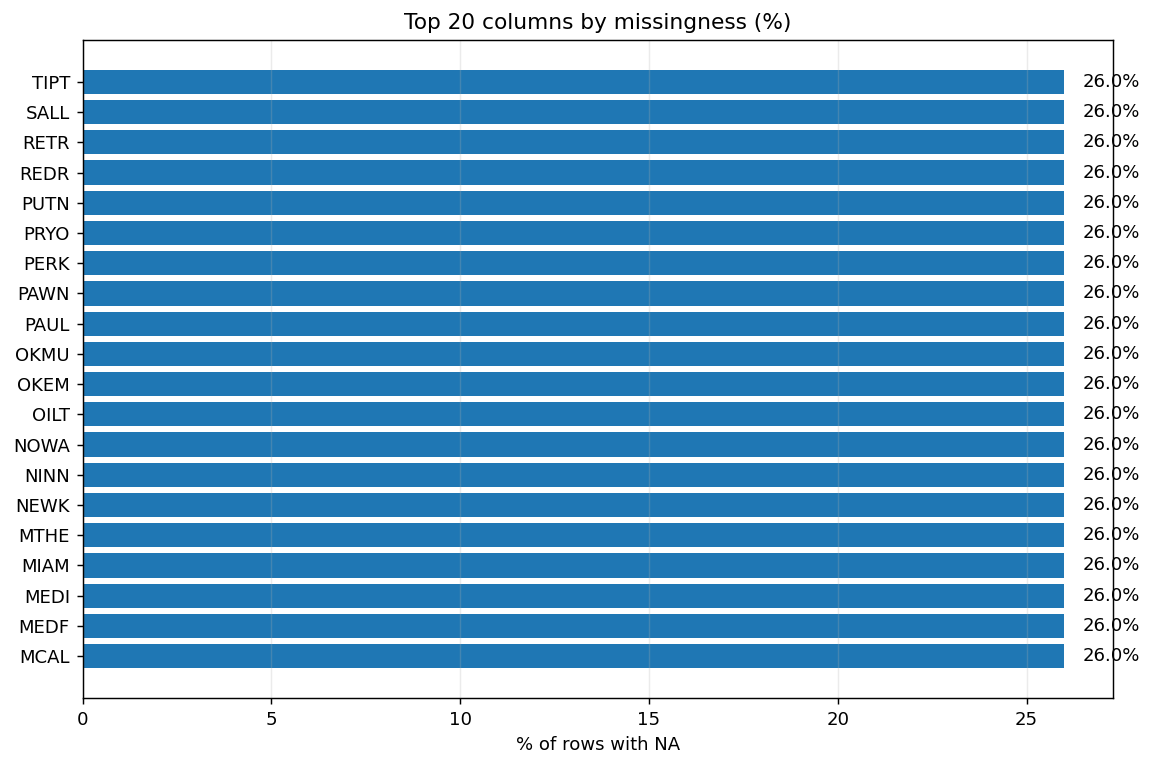

In [9]:
# Bar chart: Top-20 missingness
top_na = (df.isna().mean().sort_values(ascending=False) * 100).head(20)
fig, ax = plt.subplots(figsize=(9, 6))
ax.barh(top_na.index[::-1], top_na.values[::-1])
ax.set_title("Top 20 columns by missingness (%)")
ax.set_xlabel("% of rows with NA")
ax.grid(alpha=.25, axis="x")
for i, v in enumerate(top_na.values[::-1]):
    ax.text(v + 0.5, i, f"{v:.1f}%", va="center")
fig.tight_layout()
fig.savefig(FIG_DIR / "eda_missingness_top20.png", bbox_inches="tight")
plt.show()
plt.close(fig)


In [10]:
overall_na_pct = df.isna().mean()
print(f"Any NA cols: {(overall_na_pct>0).sum()} / {df.shape[1]}")
print(f"Median NA% across all cols: {overall_na_pct.median():.2%}")
print(f"Median NA% (stations only): {overall_na_pct[station_cols].median():.2%}")
print(f"Median NA% (exogenous only): {overall_na_pct[exo_cols].median():.2%}")


Any NA cols: 198 / 556
Median NA% across all cols: 0.00%
Median NA% (stations only): 26.00%
Median NA% (exogenous only): 0.00%


In [11]:
# Basic stats 
desc = df.drop(columns=[DATE_COL]).describe(percentiles=[.05, .25, .5, .75, .95]).T
display(desc.head(10))
desc.to_csv(ART_DIR / "describe_numeric.csv")


,count,mean,std,min,5%,25%,50%,75%,95%,max
ACME,5113.0,1.687746e+07,7.869606e+06,12000.0,3064440.0,11404200.0,16946400.0,23734800.0,28447020.0,31347900.0
ADAX,5113.0,1.623753e+07,7.905850e+06,510000.0,2660040.0,10611000.0,16299300.0,23027400.0,28151040.0,31227000.0
ALTU,5113.0,1.711919e+07,7.702989e+06,900.0,3504840.0,11674500.0,17073600.0,23903700.0,28468620.0,31411500.0
APAC,5113.0,1.701057e+07,7.883455e+06,3300.0,3165240.0,11637000.0,17062500.0,23909400.0,28655340.0,31616100.0
ARNE,5113.0,1.756017e+07,7.917965e+06,477300.0,3717780.0,11666400.0,17578500.0,24503700.0,29266020.0,32645700.0
BEAV,5113.0,1.761214e+07,7.911267e+06,300.0,4029180.0,11493600.0,17520900.0,24683100.0,29219760.0,32884800.0
BESS,5113.0,1.730407e+07,7.868140e+06,510600.0,3375120.0,11712600.0,17176500.0,24241200.0,28923300.0,31887900.0
BIXB,5113.0,1.596963e+07,8.062981e+06,74700.0,2639820.0,9794700.0,15725700.0,22940400.0,28254660.0,31702200.0
BLAC,5113.0,1.606171e+07,7.770310e+06,36000.0,3060960.0,10485760.0,15873000.0,22938300.0,27873480.0,30771900.0
BOIS,5113.0,1.868894e+07,7.649349e+06,467100.0,5783160.0,12463800.0,18885900.0,25364100.0,30047820.0,32922000.0


In [12]:
# Duplicates & date integrity
dups = df.duplicated(subset=[DATE_COL]).sum()
print("Duplicate dates:", dups)
assert dups == 0, "Found duplicate dates; consider aggregation or de-duplication."
assert df['Date'].is_monotonic_increasing, "Dates not strictly increasing."


Duplicate dates: 0


## 1.3 Correlation (stations vs ACME)

As our target is ACME, and the other stations production don't affect ours, we are gonna delete them from our data set, so our model runs faster



,pearson_r
APAC,0.977940
CHIC,0.973388
NINN,0.966652
MINC,0.966629
MEDI,0.961623
FTCB,0.959095
WASH,0.954738
PAUL,0.952054
WAUR,0.948542
ELRE,0.945159


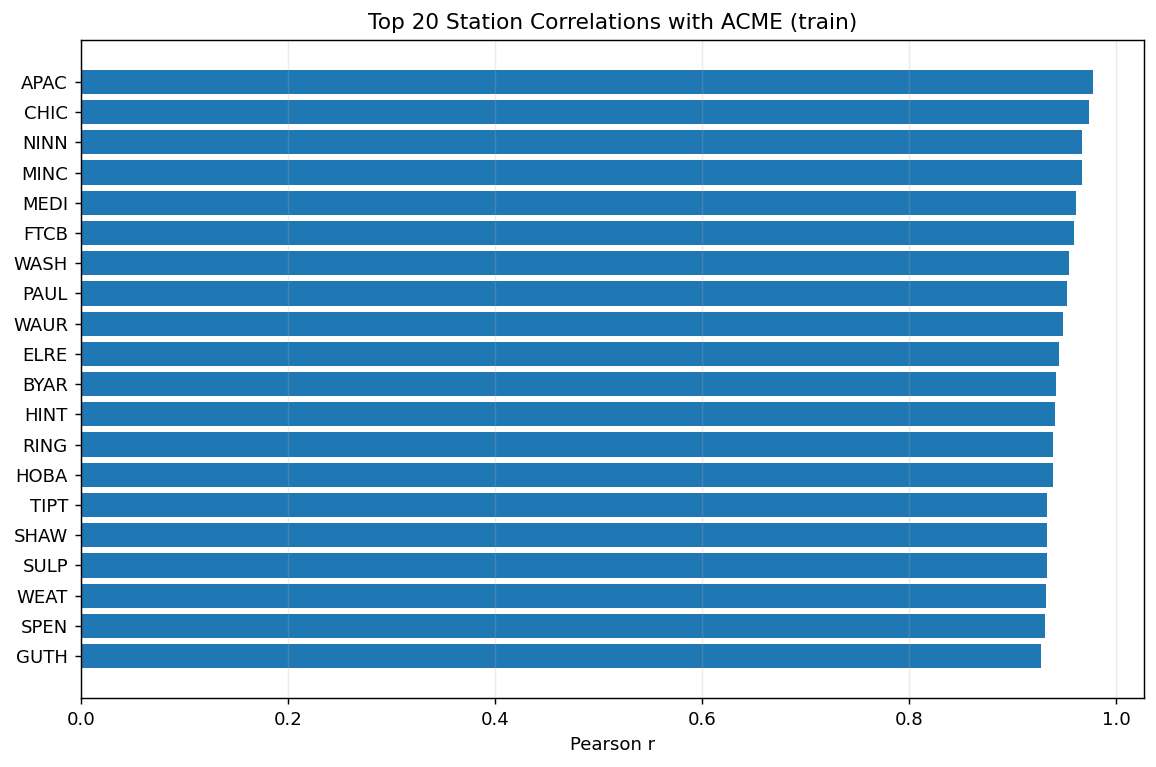

In [13]:
# Correlation: ACME vs stations (pairwise NA, safer)
corr_input = df.loc[mask_train_truth, station_cols]  # no dropna
acme_corr = corr_input.corr(min_periods=365)[target_col].sort_values(ascending=False)

topN = 20
top = acme_corr.drop(labels=[target_col]).head(topN)
display(top.to_frame("pearson_r"))

fig, ax = plt.subplots(figsize=(9, 6))
ax.barh(top.index[::-1], top.values[::-1])
ax.set_title(f"Top {topN} Station Correlations with {target_col} (train)")
ax.set_xlabel("Pearson r")
ax.grid(alpha=.25, axis="x")
fig.tight_layout()
fig.savefig(FIG_DIR / "eda_acme_top_station_corr.png", bbox_inches="tight")
plt.show()
plt.close(fig)


In [14]:
# Select columns
columns_to_keep = [
    col for col in df.columns
    if col.startswith('V') or col.startswith('PC') or col in ['ACME', 'Date']
]

# Filter the DataFrame
df = df[columns_to_keep].copy()

print("✅ Columns kept:", len(columns_to_keep))
print(df.columns.tolist()[:15], "...")
print("✅ New shape:", df.shape)

✅ Columns kept: 460
['Date', 'ACME', 'VINI', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12'] ...
✅ New shape: (6909, 460)


In [15]:
df = df.drop('VINI',axis=1)
df

,Date,ACME,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,V2073,V1785,V1817,V377,V2504,V6137,V6825,V2074,V4697,V3977
0,1994-01-01,12384900.0,-285.202347,6.018285,-24.174976,21.877974,-77.395214,-2.444447,20.420413,-13.911910,...,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00
1,1994-01-02,11908500.0,-277.450331,-37.283934,-68.825274,-36.616387,-47.573043,-44.955798,-52.979626,20.761250,...,0.0,0.00,0.02,0.0,0.0,0.00,0.0,0.01,0.01,0.00
2,1994-01-03,12470700.0,-343.566915,10.337714,-45.909605,-2.348911,-31.865502,-11.210175,-3.006734,-43.453307,...,0.0,0.00,0.00,0.0,0.0,NaN,0.0,0.00,0.00,0.00
3,1994-01-04,12725400.0,-350.773954,63.881444,19.030743,2.409239,-41.082846,-28.036183,-8.568985,-5.516248,...,NaN,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00
4,1994-01-05,10894800.0,-267.520944,12.524504,-76.004440,-108.891738,-16.768727,37.367270,-60.555546,-66.066619,...,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6904,2012-11-26,NaN,-200.995192,-48.798943,1.237346,29.034172,-88.467971,-2.585502,20.371959,37.740505,...,0.0,0.00,0.00,0.0,0.0,0.01,0.0,NaN,0.00,0.00
6905,2012-11-27,NaN,-314.769573,83.665025,50.778332,53.623425,-32.094798,-11.353654,-6.956565,-5.949328,...,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00
6906,2012-11-28,NaN,-274.335283,110.274970,37.524681,-15.910343,-37.621524,-13.254700,-50.842301,15.455133,...,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00
6907,2012-11-29,NaN,-200.411183,69.056095,2.433793,-43.986983,-51.909783,10.483883,-57.981466,-0.394278,...,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00


## 1.4 Distributions & time series (ACME)

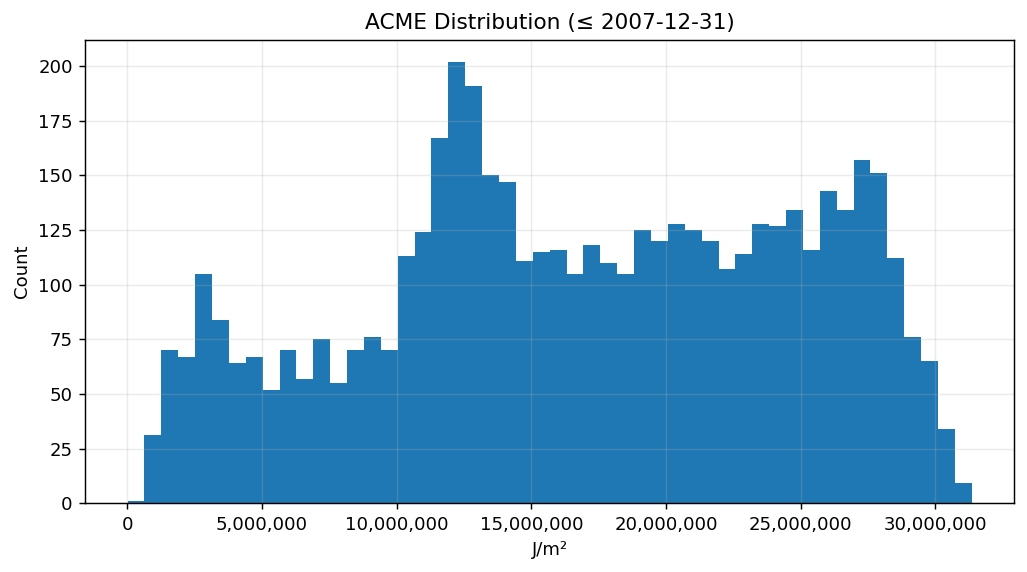

In [16]:
# 3.1 Distribution of ACME (pre-2008, where real data exists)
fig, ax = plt.subplots()
ax.hist(acme_train, bins=50)
ax.set_title("ACME Distribution (≤ 2007-12-31)")
ax.set_xlabel("J/m²"); ax.set_ylabel("Count")

# polish
ax.grid(alpha=.25)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))
fig.tight_layout()

fig.savefig(FIG_DIR / "eda_acme_hist_train.png", bbox_inches="tight")
plt.show()
plt.close(fig)



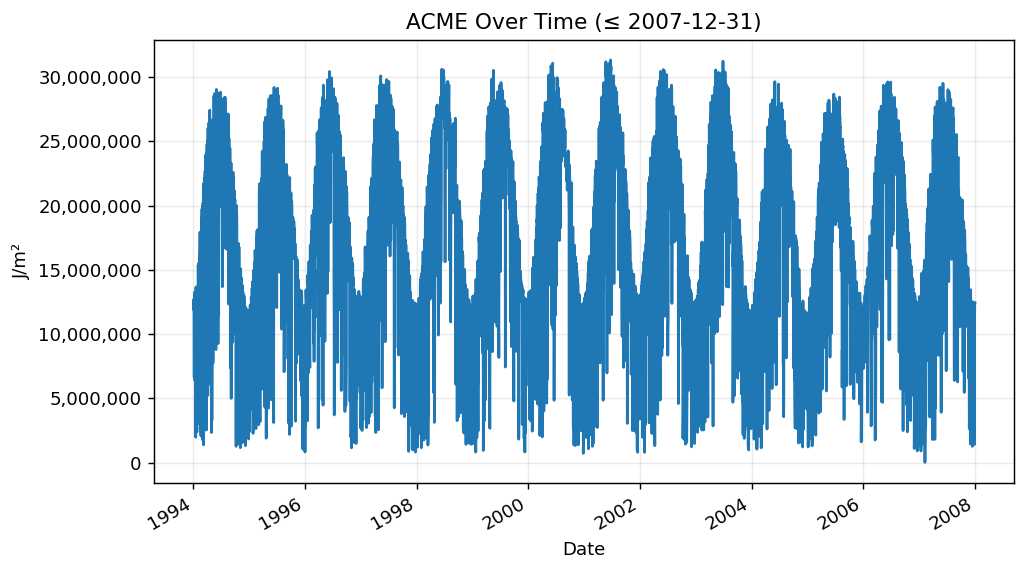

In [17]:
# ACME over time (train period)
fig, ax = plt.subplots()
ax.plot(df.loc[mask_train_truth, DATE_COL], df.loc[mask_train_truth, target_col])
ax.set_title("ACME Over Time (≤ 2007-12-31)")
ax.set_xlabel("Date"); ax.set_ylabel("J/m²")
fig.autofmt_xdate()

# polish
ax.grid(alpha=.25)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y):,}"))
fig.tight_layout()

fig.savefig(FIG_DIR / "eda_acme_time_train.png", bbox_inches="tight")
plt.show()
plt.close(fig)


## 1.5 Seasonality, Day-of-Year (DOY)

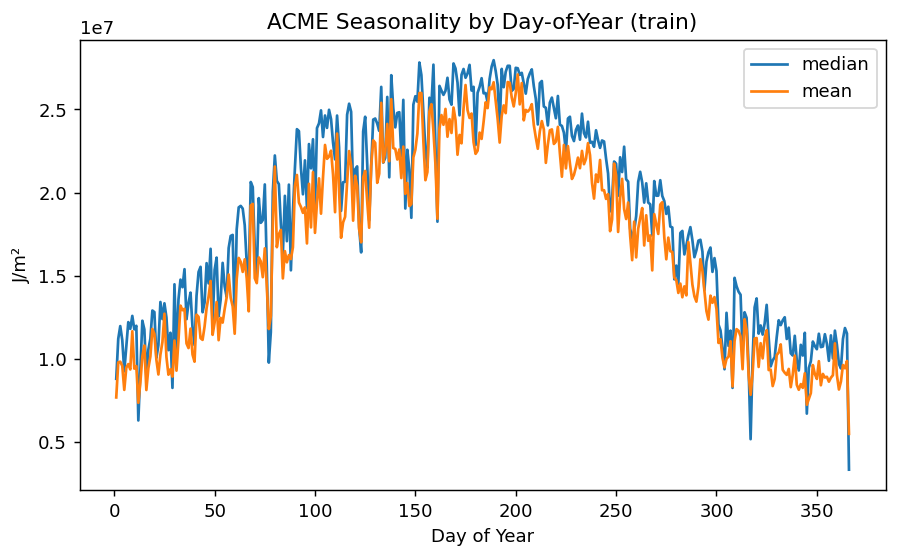

In [18]:
# 3.3 Seasonality (DOY) box/line
df["doy"] = df[DATE_COL].dt.dayofyear
season = (
    df.loc[mask_train_truth, ["doy", target_col]]
      .dropna()
      .groupby("doy")[target_col].agg(["median","mean","count"])
      .reset_index()
)

fig, ax = plt.subplots()
ax.plot(season["doy"], season["median"], label="median")
ax.plot(season["doy"], season["mean"], label="mean")
ax.set_title("ACME Seasonality by Day-of-Year (train)")
ax.set_xlabel("Day of Year"); ax.set_ylabel("J/m²")
ax.legend()
fig.savefig(FIG_DIR / "eda_acme_seasonality_doy.png", bbox_inches="tight")
plt.show()
plt.close(fig)


## 2. Feature engineering

In [19]:
# 4. Feature engineering (light, 6.1 scope)
def build_calendar_generic(df, date_col):
    cal = pd.DataFrame(index=df.index)
    cal['doy']     = df[date_col].dt.dayofyear
    cal['sin_doy'] = np.sin(2*np.pi*cal['doy']/365.25)
    cal['cos_doy'] = np.cos(2*np.pi*cal['doy']/365.25)
    cal['month']   = df[date_col].dt.month
    cal['week']    = df[date_col].dt.isocalendar().week.astype(int)
    return cal

# 4.1 Cyclical calendar features (no leakage)
cal = build_calendar_generic(df, DATE_COL)
df["doy"] = cal["doy"]
df["doy_sin"] = cal["sin_doy"]
df["doy_cos"] = cal["cos_doy"]
df["month"] = cal["month"]
df["week"] = cal["week"]

# 4.2 Optional: a couple of simple lags for the most ACME-correlated EXOGENOUS features (train-only selection)
mask_train_truth = df[DATE_COL] <= TRAIN_END

# Rank exogenous by |corr| with ACME on TRAIN
corr_exo = (
    df.loc[mask_train_truth, [target_col] + exo_cols]
      .dropna()
      .corr()[target_col]
      .drop(labels=[target_col])
      .abs()
      .sort_values(ascending=False)
)

K = 10          # keep it small for now
LAGS = [1, 7]   # daily & weekly
top_exo = corr_exo.head(K).index.tolist()

for c in top_exo:
    for l in LAGS:
        df[f"{c}_lag{l}"] = df[c].shift(l)

# Persist choices for the report/modeling
import json, os
ART_DIR.mkdir(exist_ok=True, parents=True)
with open(ART_DIR / "selected_exo_lags.json", "w") as f:
    json.dump({"top_exo": top_exo, "lags": LAGS}, f, indent=2)

print(f"Added calendar feats and lags: {len(top_exo)} exogenous × {len(LAGS)} lags = {len(top_exo)*len(LAGS)} new columns.")


Added calendar feats and lags: 10 exogenous × 2 lags = 20 new columns.


In [20]:
# Lag features for the highest-correlated exogenous features
K = 10
# Pick top correlated exo cols with ACME using train data
corr_exo = (
    df.loc[mask_train_truth, [target_col] + exo_cols]
      .dropna()
      .corr()[target_col]
      .drop(labels=[target_col])
      .abs()
      .sort_values(ascending=False)
)
top_exo = corr_exo.head(K).index.tolist()

LAGS = [1, 7]  # daily and weekly lag
for c in top_exo:
    for l in LAGS:
        df[f"{c}_lag{l}"] = df[c].shift(l)

# Keep track for later
with open(ART_DIR / "selected_exo_lags.json", "w") as f:
    json.dump({"top_exo": top_exo, "lags": LAGS}, f, indent=2)


## 3. Preprocessing pipeline (fit on train only)

In [21]:
# Define feature matrix X, target y (train scope only)
# We'll keep only engineered exogenous & calendar features for modeling (no station leak).
drop_cols = [DATE_COL] + station_cols  # remove all station columns, including ACME
feature_cols = [c for c in df.columns if c not in drop_cols]

X_all = df[feature_cols]
y_all = df[target_col]

# Split masks
mask_train = df[DATE_COL] <= TRAIN_END
mask_test  = df[DATE_COL] >= TEST_START

X_train_all = X_all.loc[mask_train]
y_train_all = y_all.loc[mask_train]

num_features = X_train_all.select_dtypes(include=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp_mean", SimpleImputer(strategy="mean")),     # first pass mean
            ("imp_zero", SimpleImputer(strategy="constant", fill_value=0.0)),  # fallback
            ("scaler", StandardScaler()),
        ]), num_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# Fit preprocess on TRAIN ONLY (to avoid leakage)
_ = preprocess.fit(X_train_all)
print("Preprocessing fitted on train. #features in num:", len(num_features))


Preprocessing fitted on train. #features in num: 482


## 4. Save transformed train features and create PPT

In [22]:
# Save transformed train features (optional, speeds up modeling notebooks)
Xtr = preprocess.transform(X_train_all)
np.save(ART_DIR / "X_train.npy", Xtr)

ytr = y_train_all.values
np.save(ART_DIR / "y_train.npy", ytr)

# Save the preprocessor for reuse
import joblib
joblib.dump(preprocess, ART_DIR / "preprocess.joblib")
joblib.dump(num_features, ART_DIR / "num_features.joblib")


['artifacts/num_features.joblib']

In [23]:
# Slides Builder: create a simple PPTX from all images in ./figures
!pip -q install python-pptx


In [24]:
from pptx import Presentation
from pptx.util import Inches, Pt
from datetime import datetime

def build_ppt_from_figures(fig_dir=FIG_DIR, out_path=Path("EDA_ACME.pptx"), title="EDA — ACME (Section 6.1)"):
    prs = Presentation()
    # Title slide
    slide = prs.slides.add_slide(prs.slide_layouts[0])
    slide.shapes.title.text = title
    slide.placeholders[1].text = f"Generated on {datetime.now():%Y-%m-%d %H:%M}"

    # Content slides
    img_paths = sorted([p for p in Path(fig_dir).glob("*.*") if p.suffix.lower() in {".png",".jpg",".jpeg",".svg"}])
    for p in img_paths:
        slide = prs.slides.add_slide(prs.slide_layouts[5])  # Title Only
        slide.shapes.title.text = p.name.replace("_", " ")
        left = Inches(0.5); top = Inches(1.2); width = Inches(9)
        slide.shapes.add_picture(str(p), left, top, width=width)

    prs.save(out_path)
    print(f"Saved: {out_path.resolve()}  (now export to PDF if needed)")

build_ppt_from_figures()

Saved: /Users/rociofaena/Documents/Machine Learning I/workgroup_project/EDA_ACME.pptx  (now export to PDF if needed)


## 5. Variable configuration

In [25]:
cutoff = pd.Timestamp('2007-12-31')

print("Date range:", df['Date'].min(), "→", df['Date'].max())
print("Rows ≤ cutoff:", (df['Date'] <= cutoff).sum())
print("ACME non-NaN overall:", df['ACME'].notna().sum())
print("Rows ≤ cutoff with ACME observed:", ((df['Date'] <= cutoff) & df['ACME'].notna()).sum())


Date range: 1994-01-01 00:00:00 → 2012-11-30 00:00:00
Rows ≤ cutoff: 5113
ACME non-NaN overall: 5113
Rows ≤ cutoff with ACME observed: 5113


In [26]:
target = 'ACME'

# numeric features only (skip Date & target)
all_features     = [c for c in df.columns if c not in ['Date', target]]
numeric_features = [c for c in all_features if pd.api.types.is_numeric_dtype(df[c])]

# keep any feature with some data BEFORE cutoff (we train on the observed era)
train_rows = df['Date'] <= cutoff
train_features = [c for c in numeric_features if df.loc[train_rows, c].notna().any()]

# exist AFTER cutoff (for future prediction only)
post_rows = df['Date'] > cutoff
future_features = [c for c in train_features if df.loc[post_rows, c].notna().any()]

numerical_vars   = train_features          
# We don't have vategorical variables

print(f"Numerical variables ({len(numerical_vars)}): first 10 ->", numerical_vars[:10])


Numerical variables (482): first 10 -> ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']


## 6. Linear model

Test/Val split

In [27]:
# 20%/80% split 

block_mask = (df['Date'] <= cutoff) & df[target].notna()
block = df.loc[block_mask, ['Date', target] + numerical_vars].copy()

# features/target
X_block = block[numerical_vars].replace([np.inf, -np.inf], np.nan)
y_block = block[target]

# split index
split_idx = int(len(X_block) * 0.80)
X_train, X_val = X_block.iloc[:split_idx].copy(), X_block.iloc[split_idx:].copy()
y_train, y_val = y_block.iloc[:split_idx].copy(), y_block.iloc[split_idx:].copy()

# apply categorical typing (kept for structure)
X_train_processed = X_train.copy()
X_val_processed   = X_val.copy()

print(f"Train shape: {X_train_processed.shape} | Val shape: {X_val_processed.shape}")

Train shape: (4090, 482) | Val shape: (1023, 482)


Data Preprocessing Configuration

In [28]:
# Automatically select all PC and V columns
pc_vars = [c for c in df.columns if c.startswith('PC')]
weather_vars = [c for c in df.columns if c.startswith('V')]

# Calendar features (already built with build_calendar)
calendar_vars = ['cos_doy', 'sin_doy', 'month', 'week']

# Combine everything
selected_vars = pc_vars + weather_vars + calendar_vars

print(f"✅ Selected variables for modeling: {len(selected_vars)} columns")
print("First 10:", selected_vars[:10])

✅ Selected variables for modeling: 481 columns
First 10: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']


In [29]:
selected_vars  = pc_vars + weather_vars + calendar_vars

# Choose how to impute + scale + PCA
fill_numerical_na = "mean"       
scaling_type = "min-max"   
encoding_type = "ordinal"
use_pca = False        
pca_variance = 0.90    

# Final numeric variable list from your selected frame
numerical_vars = [c for c in selected_vars 
                  if c in X_train_processed.columns 
                  and pd.api.types.is_numeric_dtype(X_train_processed[c])]

print(f"Numerical vars ({len(numerical_vars)}): {numerical_vars[:10]} ...")


Numerical vars (479): ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'] ...


Regression Model 

In [30]:
alpha_values = np.logspace(-3, 3, 13)  
regression_type = ""
print("Alpha grid:", alpha_values)

Alpha grid: [1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02 3.16227766e+02
 1.00000000e+03]


✓ Filled numerical missing values with mean
✓ Applied MinMax scaling to numerical variables
✓ Filled numerical missing values with mean
✓ Filled numerical missing values with mean
✓ Applied MinMax scaling to numerical variables
✓ Filled numerical missing values with mean
✓ Filled numerical missing values with mean
✓ Applied MinMax scaling to numerical variables
✓ Filled numerical missing values with mean
✓ Filled numerical missing values with mean
✓ Applied MinMax scaling to numerical variables
✓ Filled numerical missing values with mean
✓ Filled numerical missing values with mean
✓ Applied MinMax scaling to numerical variables
✓ Filled numerical missing values with mean
α= 0.0010 | CV MAPE=48.35%  | CV RMSE=5859538  | CV MAE=3681709
✓ Filled numerical missing values with mean
✓ Applied MinMax scaling to numerical variables
✓ Filled numerical missing values with mean
✓ Filled numerical missing values with mean
✓ Applied MinMax scaling to numerical variables
✓ Filled numerical missing v

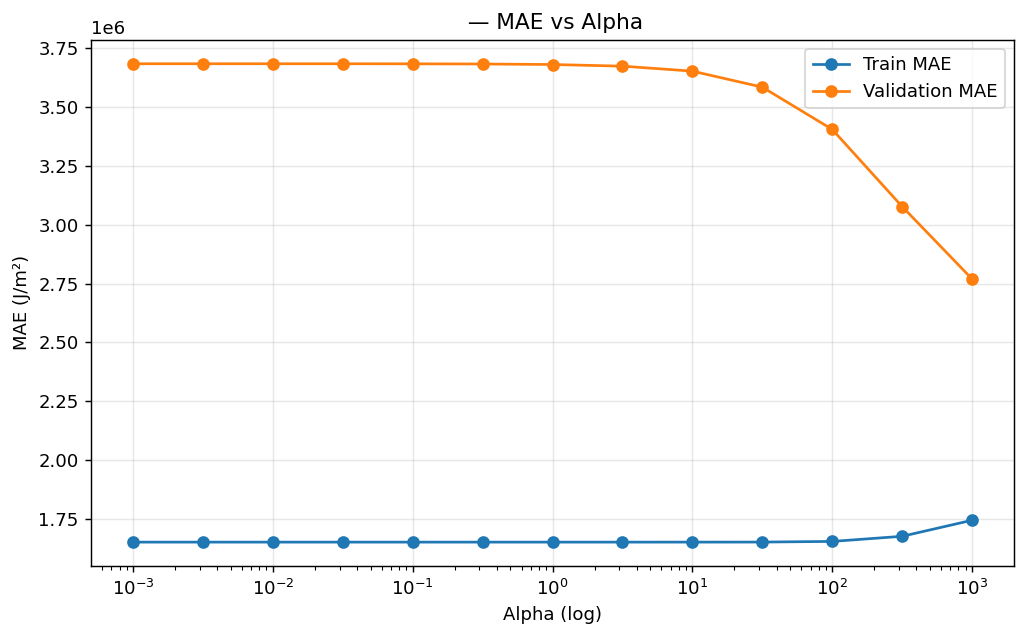

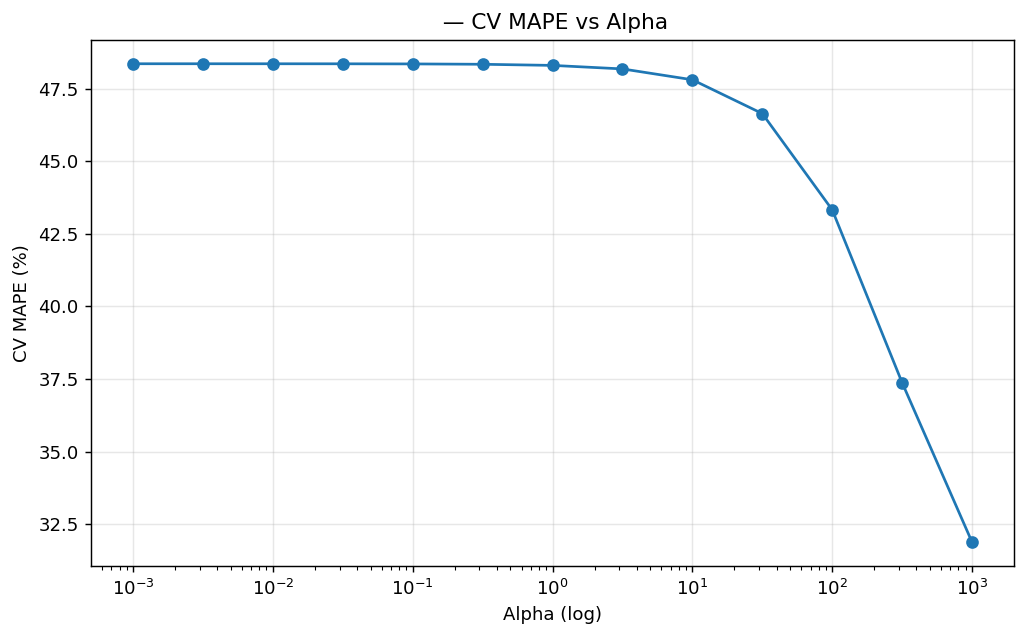

In [31]:
# TimeSeriesSplit CV (select by MAPE), plus MAE tracking & plot
tscv = TimeSeriesSplit(n_splits=5)

cv_records = []

for alpha in alpha_values:
    fold_mapes, fold_rmses = [], []
    fold_mae_tr, fold_mae_va = [] , []  

    for fold_idx, (tr_idx, va_idx) in enumerate(tscv.split(X_train_processed)):
        X_tr_fold = X_train_processed.iloc[tr_idx][numerical_vars]
        y_tr_fold = y_train.iloc[tr_idx]
        X_va_fold = X_train_processed.iloc[va_idx][numerical_vars]
        y_va_fold = y_train.iloc[va_idx]

        # fit preprocessing on fold-train only
        X_tr_proc, imp, scl, enc, pca_obj = preprocess_data(
            X_tr_fold,
            numerical_vars=numerical_vars,
            categorical_vars=[],               # no categorical
            scaling_type=scaling_type,
            encoding_type=encoding_type,       # ignored (no categorical)
            use_pca=use_pca,
            pca_variance=pca_variance,
            fill_numerical_na=fill_numerical_na,
            fill_categorical_na="none"
        )

        # transform fold-val with fitted artifacts
        X_va_proc, _, _, _, _ = preprocess_data(
            X_va_fold,
            numerical_vars=numerical_vars,
            categorical_vars=[],
            scaling_type=scaling_type,
            encoding_type=encoding_type,
            use_pca=use_pca,
            pca_variance=pca_variance,
            fill_numerical_na=fill_numerical_na,
            fill_categorical_na="none",
            fitted_imputer=imp,
            fitted_scaler=scl,
            fitted_encoder=None,
            fitted_pca=pca_obj
        )

        # align y with processed X indices
        y_tr_use = y_tr_fold.loc[X_tr_proc.index]
        y_va_use = y_va_fold.loc[X_va_proc.index]

        # pick model
        if regression_type.lower() == "ridge":
            model = Ridge(alpha=alpha, random_state=42)
        else:
            model = Lasso(alpha=alpha, random_state=42, max_iter=10000)

        model.fit(X_tr_proc, y_tr_use)

        # --- predictions (train + val) for MAE curves  
        y_tr_hat = model.predict(X_tr_proc)             
        y_va_hat = model.predict(X_va_proc)

        # collect metrics
        fold_mae_tr.append(mean_absolute_error(y_tr_use, y_tr_hat))   
        fold_mae_va.append(mean_absolute_error(y_va_use, y_va_hat))   
        fold_mapes.append(mean_absolute_percentage_error(y_va_use, y_va_hat) * 100)
        fold_rmses.append(np.sqrt(mean_squared_error(y_va_use, y_va_hat)))

    cv_records.append({
        "alpha": alpha,
        "cv_mape": float(np.mean(fold_mapes)),
        "cv_rmse": float(np.mean(fold_rmses)),
        "cv_mae":  float(np.mean(fold_mae_va)),     
        "cv_mae_tr": float(np.mean(fold_mae_tr)),   
    })
    print(f"α={alpha:>7.4f} | CV MAPE={np.mean(fold_mapes):.2f}%  | "
          f"CV RMSE={np.mean(fold_rmses):.0f}  | CV MAE={np.mean(fold_mae_va):.0f}")  

# pick best alpha (lowest CV MAE)
cv_df = pd.DataFrame(cv_records)                
best_alpha = float(cv_df.loc[cv_df["cv_mae"].idxmin(), "alpha"])
print("\nBest alpha by CV MAE:", best_alpha)

# sorted copy for plotting by alpha
cv_df_plot = cv_df.sort_values("alpha")

# Refit preprocessing on FULL TRAIN, evaluate on VAL 
Xtr_proc, imp_full, scl_full, enc_full, pca_full = preprocess_data(
    X_train_processed[numerical_vars],
    numerical_vars=numerical_vars,
    categorical_vars=[],
    scaling_type=scaling_type,
    encoding_type=encoding_type,
    use_pca=use_pca,
    pca_variance=pca_variance,
    fill_numerical_na=fill_numerical_na,
    fill_categorical_na="none"
)

Xva_proc, _, _, _, _ = preprocess_data(
    X_val_processed[numerical_vars],
    numerical_vars=numerical_vars,
    categorical_vars=[],
    scaling_type=scaling_type,
    encoding_type=encoding_type,
    use_pca=use_pca,
    pca_variance=pca_variance,
    fill_numerical_na=fill_numerical_na,
    fill_categorical_na="none",
    fitted_imputer=imp_full,
    fitted_scaler=scl_full,
    fitted_encoder=None,
    fitted_pca=pca_full
)

ytr_use = y_train.loc[Xtr_proc.index]
yva_use = y_val.loc[Xva_proc.index]

if regression_type.lower() == "ridge":
    best_model = Ridge(alpha=best_alpha, random_state=42)
else:
    best_model = Lasso(alpha=best_alpha, random_state=42, max_iter=10000)

best_model.fit(Xtr_proc, ytr_use)

yva_pred = best_model.predict(Xva_proc)
val_mape = mean_absolute_percentage_error(yva_use, yva_pred) * 100
val_rmse = np.sqrt(mean_squared_error(yva_use, yva_pred))
val_mae  = mean_absolute_error(yva_use, yva_pred)

print(f"\nHoldout VAL — MAPE: {val_mape:.2f}% | RMSE: {val_rmse:.0f} | MAE: {val_mae:.0f}")

# MAE plot (train & validation)
cv_df_plot = cv_df.sort_values("alpha")
plt.figure(figsize=(8,5))
plt.plot(cv_df_plot["alpha"], cv_df_plot["cv_mae_tr"], marker='o', label="Train MAE")
plt.plot(cv_df_plot["alpha"], cv_df_plot["cv_mae"],    marker='o', label="Validation MAE")
plt.xscale('log')
plt.xlabel("Alpha (log)")
plt.ylabel("MAE (J/m²)")
plt.title(f"{regression_type.upper()} — MAE vs Alpha")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# (Optional) keep your original MAPE plot too
plt.figure(figsize=(8,5))
plt.plot(cv_df_plot["alpha"], cv_df_plot["cv_mape"], marker='o')
plt.xscale('log')
plt.xlabel("Alpha (log)")
plt.ylabel("CV MAPE (%)")
plt.title(f"{regression_type.upper()} — CV MAPE vs Alpha")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

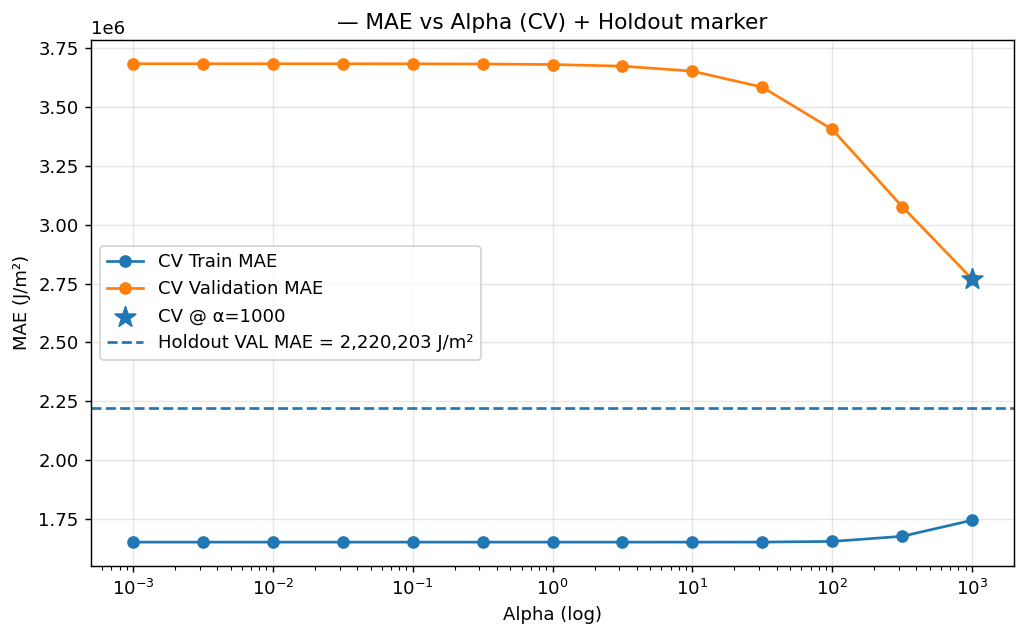

In [33]:
# MAE plot (CV Train & CV Val), + marker at best_alpha, + holdout line 
cv_df_plot = pd.DataFrame(cv_records).sort_values("alpha")

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(cv_df_plot["alpha"], cv_df_plot["cv_mae_tr"], marker='o', label="CV Train MAE")
ax.plot(cv_df_plot["alpha"], cv_df_plot["cv_mae"],    marker='o', label="CV Validation MAE")

# find the CV point closest to best_alpha
idx = (cv_df_plot["alpha"] - best_alpha).abs().argmin()
cv_alpha   = float(cv_df_plot.iloc[idx]["alpha"])
cv_mae_val = float(cv_df_plot.iloc[idx]["cv_mae"])

# star marker at CV MAE for best_alpha
ax.scatter([cv_alpha], [cv_mae_val], s=140, marker='*', zorder=5, label=f"CV @ α={cv_alpha:g}")

# dashed line for holdout VAL MAE (after refit on full train)
ax.axhline(val_mae, linestyle="--", linewidth=1.5, label=f"Holdout VAL MAE = {val_mae:,.0f} J/m²")

# cosmetics
ax.set_xscale('log')
ax.set_xlabel("Alpha (log)")
ax.set_ylabel("MAE (J/m²)")
ax.set_title("— MAE vs Alpha (CV) + Holdout marker")
ax.grid(alpha=0.3)
ax.legend()
fig.tight_layout()
fig.savefig(FIG_DIR / f"{regression_type.lower()}_mae_vs_alpha_with_holdout.png", bbox_inches="tight")
plt.show()

In [34]:
mean_y_holdout = yva_use.mean()

print("\n BEST LINEAR MODEL — HOLDOUT SUMMARY")
print(f"Model:        {best_model}")
print(f"Best alpha:   {best_alpha:g}")
print(f"Holdout MAPE: {val_mape:.2f}%")
print(f"Holdout MAE:  {val_mae:,.0f} J/m²  ({100*val_mae/mean_y_holdout:.2f}% of mean)")
print(f"Holdout RMSE: {val_rmse:,.0f} J/m²")


 BEST LINEAR MODEL — HOLDOUT SUMMARY
Model:        Lasso(alpha=1000.0, max_iter=10000, random_state=42)
Best alpha:   1000
Holdout MAPE: 82.09%
Holdout MAE:  2,220,203 J/m²  (12.87% of mean)
Holdout RMSE: 3,161,219 J/m²


## 7. Non linear model

In [35]:
#RandomizedSearch + TimeSeriesSplit (MAE-optimized)
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline as SkPipe
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import randint, uniform

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# 0) Preconditions

assert 'df' in globals(), "You must provide a DataFrame 'df'."
assert 'target' in globals(), "You must define 'target' as the target column name."
assert target in df.columns, f"'{target}' not found in df.columns"
assert 'Date' in df.columns, "This notebook requires a 'Date' column for time-series splits."
assert 'cutoff' in globals(), "Define a 'cutoff' (pd.Timestamp or parseable str) for the time-based split."

# Normalize cutoff to Timestamp
cutoff = pd.Timestamp(cutoff)


# 1) Build X/y and time split using cutoff (TS only)
drop_cols = [target, 'Date']
features = [c for c in df.columns if c not in drop_cols]

# Train/Test base on non-null target only
base_df = df.loc[df[target].notna()].copy()
base_df['Date'] = pd.to_datetime(base_df['Date'])
base_df = base_df.sort_values('Date').reset_index(drop=True)

# Primary split by cutoff (TS only)
train_df = base_df.loc[base_df['Date'] <= cutoff].copy()
test_df  = base_df.loc[base_df['Date'] >  cutoff].copy()

# Fallback if cutoff leaves empty test -> keep TS by using the last 20% as test
if len(test_df) == 0:
    n = len(base_df)
    test_n = max(1, int(round(n * 0.20)))
    train_df = base_df.iloc[:-test_n].copy()
    test_df  = base_df.iloc[-test_n:].copy()

X_train, y_train = train_df[features], train_df[target].astype(float)
X_test,  y_test  = test_df[features],  test_df[target].astype(float)

assert len(X_train) > 0, "Train is empty after split."
assert len(X_test)  > 0, "Test is empty after split."

print(f"Train: {X_train.shape} | Test: {X_test.shape}")
print("Train period:", train_df['Date'].min(), "→", train_df['Date'].max())
print("Test  period:", test_df['Date'].min(),  "→", test_df['Date'].max())

# 2) Target scale diagnostics
print("\nTarget scale diagnostic (train/test):")
print("Train describe:\n", y_train.describe(percentiles=[.1,.5,.9]).to_string())
print("Test  describe:\n",  y_test.describe(percentiles=[.1,.5,.9]).to_string())

# 3) Columns: numeric/categorical
num_cols = [c for c in X_train.columns if np.issubdtype(pd.Series(X_train[c]).dtype, np.number)]
cat_cols = [c for c in X_train.columns if c not in num_cols]
print(f"\nNumeric: {len(num_cols)} | Categorical: {len(cat_cols)}")

# 4) Preprocessing pipelines (tree-friendly)
def make_onehot():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

# Numeric: impute only (no scaling for trees)
num_pipe = SkPipe(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

# Categorical (only used if you actually have cats)
cat_pipe = SkPipe(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  make_onehot()),
])

# Apply high-cardinality caps only if there are categorical cols
if len(cat_cols) > 0:
    for param in ["onehot__min_frequency", "onehot__max_categories"]:
        try:
            if param.endswith("min_frequency"):
                cat_pipe.set_params(**{param: 0.01})   # group very rare categories
            else:
                cat_pipe.set_params(**{param: 60})     # cap categories
        except Exception:
            pass

# Build the column transformer (skip empty transformers cleanly)
transforms = [("num", num_pipe, num_cols)]
if len(cat_cols) > 0:
    transforms.append(("cat", cat_pipe, cat_cols))

preprocess = ColumnTransformer(
    transformers=transforms,
    remainder="drop",
)

# 5) Safe error metrics
def safe_mape(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs(y_true - y_pred) / denom)

def smape(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum((np.abs(y_true) + np.abs(y_pred)) / 2.0, eps)
    return np.mean(np.abs(y_pred - y_true) / denom)

# 6) Base pipeline
gbr = GradientBoostingRegressor(
    loss="squared_error",   # keeps parity with your best historical run
    random_state=42
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", gbr)
])

# 7) Search spaces (Randomized) — robust & tight around your good region
gbr_space = {
    "model": [GradientBoostingRegressor(random_state=42)],
    "model__loss": ["huber"],                 
    "model__alpha": uniform(0.88, 0.10),      
    "model__n_estimators": randint(700, 1500),
    "model__learning_rate": uniform(0.008, 0.03),
    "model__max_depth": randint(3, 6),
    "model__min_samples_leaf": randint(20, 100),
    "model__min_samples_split": randint(40, 250),
    "model__subsample": uniform(0.55, 0.35),  
    "model__max_features": ["sqrt", 0.6, 0.5, 0.4, None],
}

search_spaces = [gbr_space]

if HAS_XGB:
    xgb = XGBRegressor(
        objective="reg:squarederror",  
        tree_method="hist",
        n_jobs=-1,
        random_state=42
    )
    xgb_space = {
        "model": [xgb],
        "model__n_estimators": randint(300, 900),
        "model__learning_rate": uniform(0.03, 0.09),  
        "model__max_depth":     randint(3, 8),        
        "model__subsample":     uniform(0.7, 0.3),    
        "model__colsample_bytree": uniform(0.7, 0.3), 
        "model__reg_lambda":    uniform(0.0, 6.0),    
    }
    search_spaces.append(xgb_space)

# 8) TimeSeries & scorers
X_train_ord, y_train_ord = X_train, y_train
n_splits = 3 if len(X_train_ord) >= 40 else 2
cv = TimeSeriesSplit(n_splits=n_splits)

mae_scorer  = make_scorer(mean_absolute_error, greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# 9) RandomizedSearchCV — refit on MAE, with a fits budget
cv_splits = cv.get_n_splits()
TOTAL_FITS_BUDGET = 60  # change to 60/75/90 as you prefer
n_iter_budget = max(10, TOTAL_FITS_BUDGET // cv_splits)
print(f"Using n_iter={n_iter_budget} with {cv_splits} CV splits -> ~{n_iter_budget*cv_splits} fits")

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=search_spaces,
    n_iter=n_iter_budget,                    # budgeted iterations
    scoring={"mae": mae_scorer, "mape": mape_scorer},
    refit="mae",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    search.fit(X_train_ord, y_train_ord)

# 10) Search results
print("\n=== BEST MODEL (refit on full train) ===")
print(search.best_estimator_)
print("\nBest params:\n", search.best_params_)
print(f"\nBest CV MAE: {abs(search.best_score_):.6f}")  # best_score_ is MAE now

cvres = pd.DataFrame(search.cv_results_)

# Show MAE leaderboard (refit metric)
if "rank_test_mae" in cvres.columns:
    cvres["mean_test_mae_pos"]  = cvres["mean_test_mae"].abs()
    cvres["mean_train_mae_pos"] = cvres["mean_train_mae"].abs()
    print("\n=== TOP RESULTS (lower MAE is better) ===")
    print(cvres.sort_values("rank_test_mae")[[
        "rank_test_mae","mean_test_mae_pos","std_test_mae",
        "mean_train_mae_pos","std_train_mae","params"
    ]].head(12).to_string(index=False))

# MAPE rankings for context
if "rank_test_mape" in cvres.columns:
    cvres["mean_test_mape_pos"]  = cvres["mean_test_mape"].abs()
    cvres["mean_train_mape_pos"] = cvres["mean_train_mape"].abs()
    print("\n=== TOP RESULTS (lower MAPE is better) ===")
    print(cvres.sort_values("rank_test_mape")[[
        "rank_test_mape","mean_test_mape_pos","std_test_mape",
        "mean_train_mape_pos","std_train_mape","params"
    ]].head(12).to_string(index=False))

# 11) Test evaluation (post-cutoff window)
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

test_mape_raw  = mean_absolute_percentage_error(y_test, y_pred)
test_mape_safe = safe_mape(y_test, y_pred)
test_smape     = smape(y_test, y_pred)
test_mae       = mean_absolute_error(y_test, y_pred)
test_rmse      = mean_squared_error(y_test, y_pred, squared=False)

print("\n TEST METRICS")
print(f"MAPE (raw) : {test_mape_raw:.6f}")
print(f"MAPE (safe): {test_mape_safe:.6f}")
print(f"sMAPE      : {test_smape:.6f}")
print(f"MAE        : {test_mae:.6f}")
print(f"RMSE       : {test_rmse:.6f}")

# 12) Final summary
print(f"\n BEST TEST MAE: {test_mae:.6f}")


Train: (4090, 482) | Test: (1023, 482)
Train period: 1994-01-01 00:00:00 → 2005-03-13 00:00:00
Test  period: 2005-03-14 00:00:00 → 2007-12-31 00:00:00

Target scale diagnostic (train/test):
Train describe:
 count    4.090000e+03
mean     1.678264e+07
std      7.991817e+06
min      7.206000e+05
10%      4.887270e+06
50%      1.678725e+07
90%      2.745174e+07
max      3.134790e+07
Test  describe:
 count    1.023000e+03
mean     1.725657e+07
std      7.352260e+06
min      1.200000e+04
10%      7.114500e+06
50%      1.766760e+07
90%      2.706630e+07
max      2.963910e+07

Numeric: 482 | Categorical: 0
Using n_iter=20 with 3 CV splits -> ~60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits

=== BEST MODEL (refit on full train) ===
Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(stra

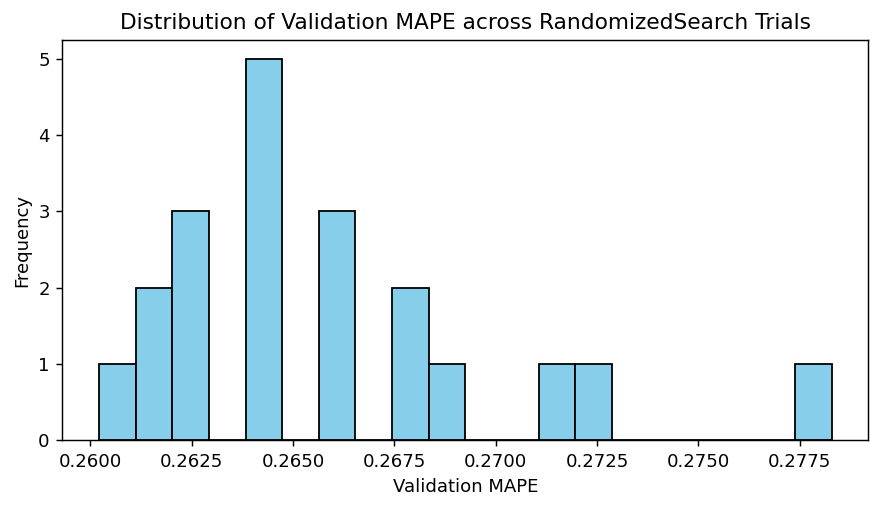

In [36]:
import matplotlib.pyplot as plt

cvres["mean_test_mape_pos"] = cvres["mean_test_mape"].abs()
plt.figure(figsize=(8,4))
plt.hist(cvres["mean_test_mape_pos"], bins=20, color="skyblue", edgecolor="k")
plt.title("Distribution of Validation MAPE across RandomizedSearch Trials")
plt.xlabel("Validation MAPE")
plt.ylabel("Frequency")
plt.show()

Test MAE: 2,127,081 J/m²
P90 abs error: 5,017,778 J/m²
P95 abs error: 6,949,730 J/m²


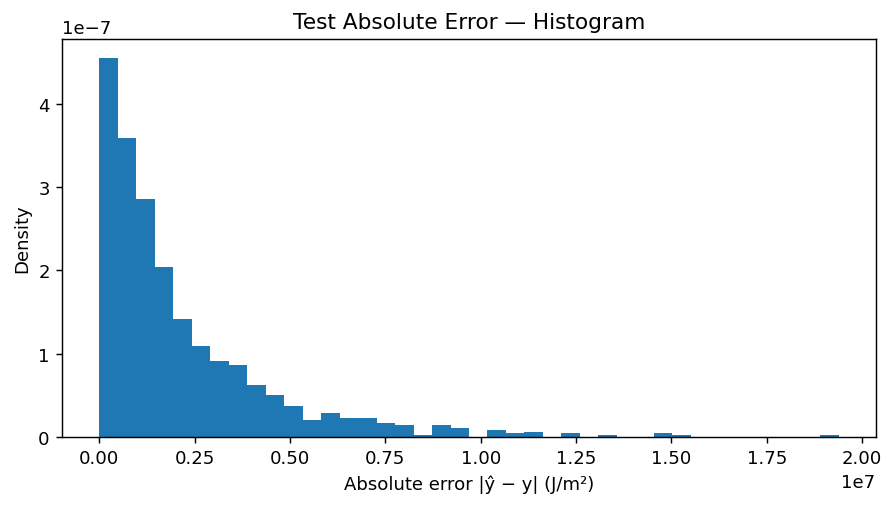

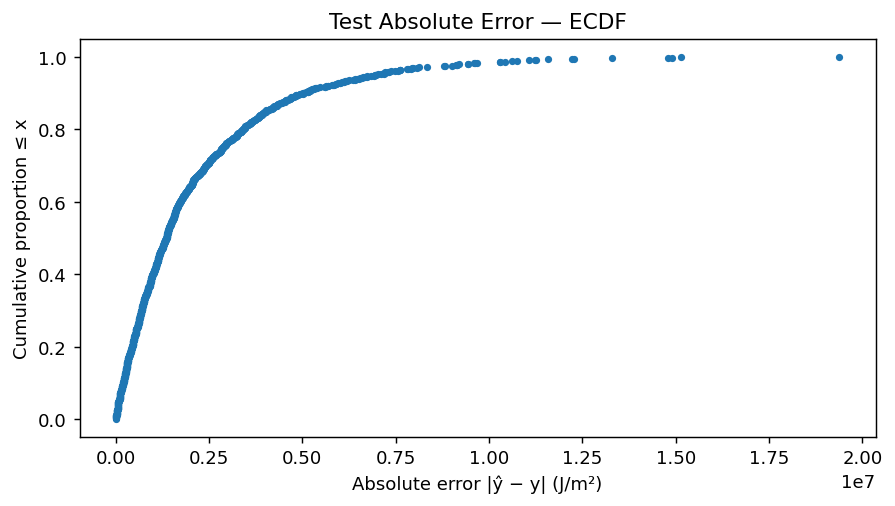

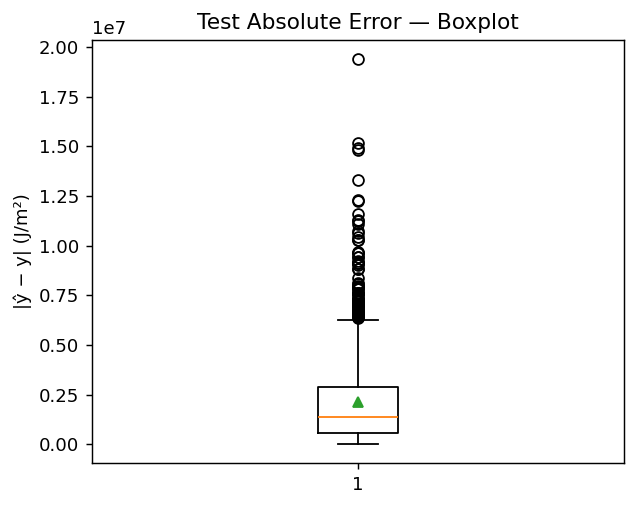

In [37]:
# 1) Per-sample absolute errors on TEST
abs_err = np.abs(y_test.values - y_pred)
mae = abs_err.mean()
p90 = np.percentile(abs_err, 90)
p95 = np.percentile(abs_err, 95)

print(f"Test MAE: {mae:,.0f} J/m²")
print(f"P90 abs error: {p90:,.0f} J/m²")
print(f"P95 abs error: {p95:,.0f} J/m²")

# A) Histogram (distribution shape) 
plt.figure(figsize=(7,4))
plt.hist(abs_err, bins=40, density=True)
plt.xlabel("Absolute error |ŷ − y| (J/m²)")
plt.ylabel("Density")
plt.title("Test Absolute Error — Histogram")
plt.tight_layout()
plt.show()

# B) ECDF (coverage view) 
x = np.sort(abs_err)
y = np.arange(1, len(x)+1) / len(x)
plt.figure(figsize=(7,4))
plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel("Absolute error |ŷ − y| (J/m²)")
plt.ylabel("Cumulative proportion ≤ x")
plt.title("Test Absolute Error — ECDF")
plt.tight_layout()
plt.show()

# C) Boxplot (compact summary) ----
plt.figure(figsize=(5,4))
plt.boxplot(abs_err, vert=True, showmeans=True)
plt.ylabel("|ŷ − y| (J/m²)")
plt.title("Test Absolute Error — Boxplot")
plt.tight_layout()
plt.show()

## 8. Feature Importance


=== Feature importances (native) — top 30 transformed features ===
feature_transformed  importance
            doy_cos    0.309426
                PC2    0.120611
                PC1    0.081288
           PC1_lag1    0.045726
           PC1_lag7    0.029825
            doy_sin    0.028430
              V1800    0.025982
              V1369    0.022212
                doy    0.020466
              V6265    0.020315
               week    0.019584
              V4680    0.012733
                PC3    0.011120
              V2089    0.009254
              V2520    0.008685
              V5400    0.007581
              V3385    0.006832
              month    0.005636
               PC10    0.004745
              V3530    0.004639
              V6393    0.004047
              V4969    0.003839
              V6985    0.003761
              V3240    0.003735
                PC7    0.003631
              V3529    0.003598
              V5705    0.003439
              V1080    0.003333
    

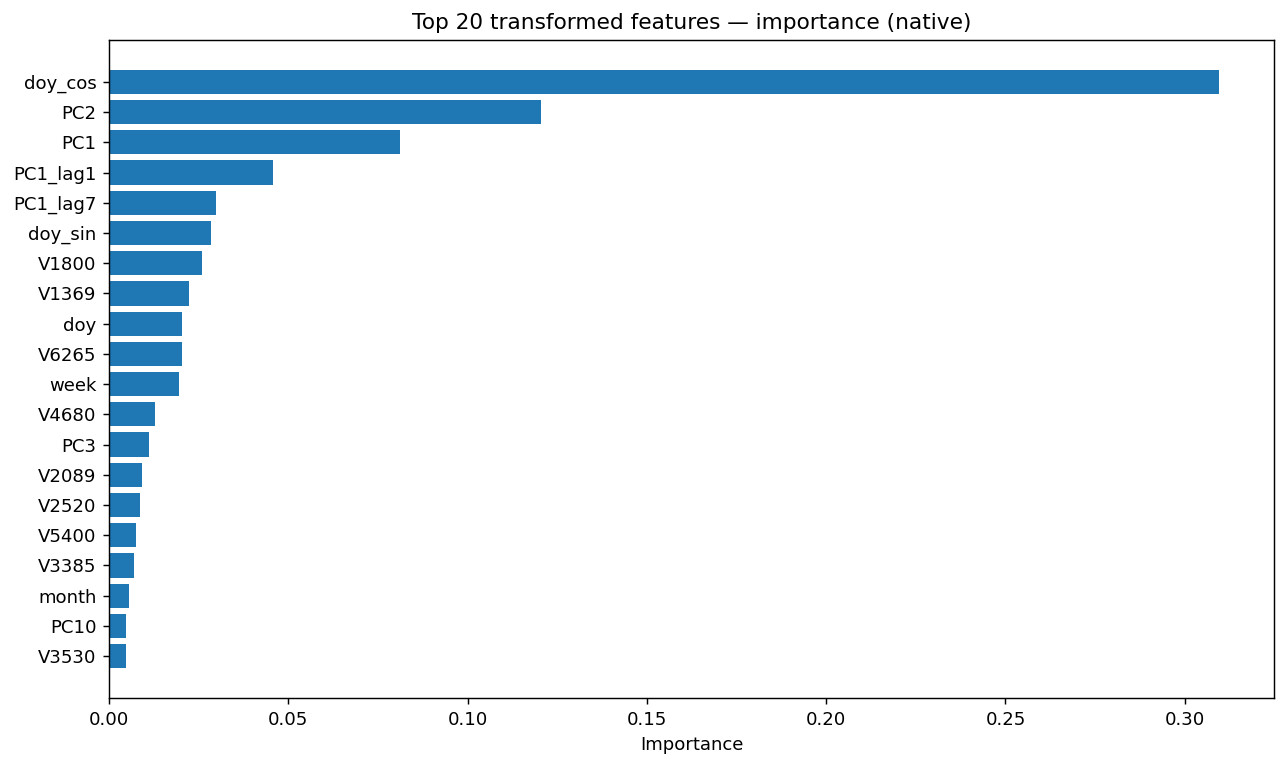

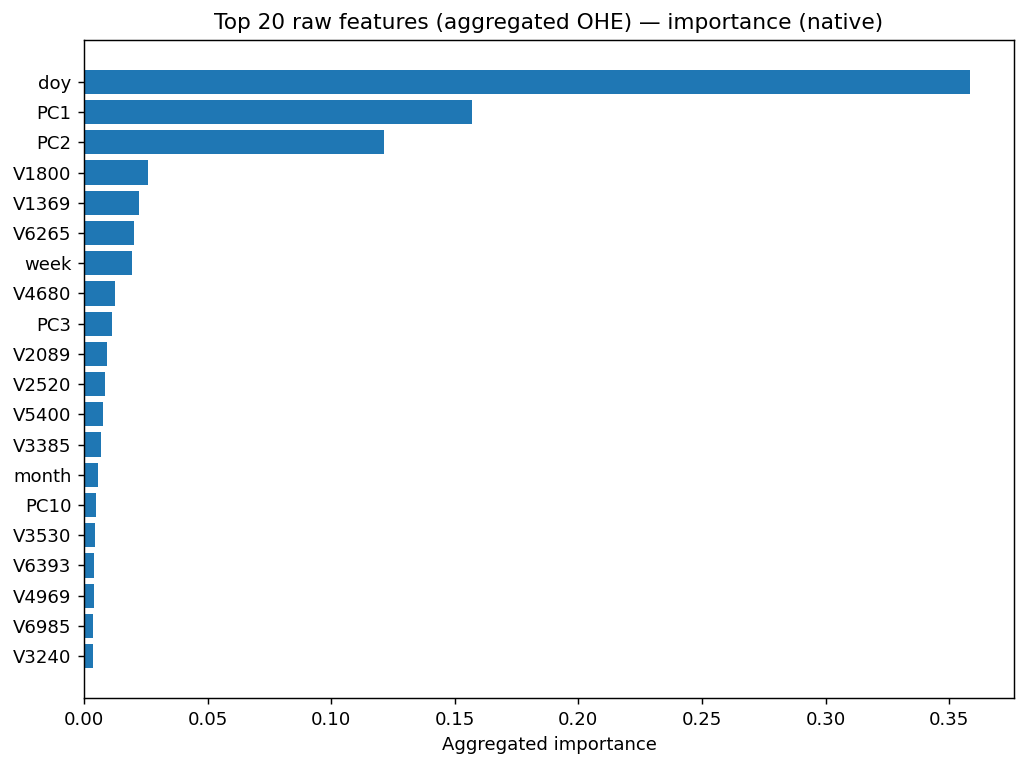

In [38]:
# Feature importance 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

assert 'best_model' in globals(), "Run the search first so best_model exists."
assert 'preprocess' in globals() or 'pipe' in globals(), "Preprocessor must exist."

pipe_fitted = best_model  
prep = pipe_fitted.named_steps['prep']

# Build transformed feature-name list (numeric + OHE categorical)
def get_transformed_feature_names(prep, num_cols, cat_cols):
    names = []
    # numeric block 
    if len(num_cols) > 0:
        names.extend(list(num_cols))
    # categorical block 
    if len(cat_cols) > 0:
        ohe = prep.named_transformers_['cat'].named_steps['onehot']
        try:
            ohe_names = ohe.get_feature_names_out(cat_cols)
        except Exception:
            ohe_names = ohe.get_feature_names(cat_cols)
        names.extend(list(ohe_names))
    return names

feat_names = get_transformed_feature_names(prep, num_cols=num_cols, cat_cols=cat_cols)

# Try native importances first
model = pipe_fitted.named_steps['model']
importances = None
kind = None

if hasattr(model, "feature_importances_"):
    importances = np.asarray(model.feature_importances_, dtype=float)
    kind = "native"
elif hasattr(model, "coef_"):
    coef = model.coef_
    # Handle multi-output just in case
    coef = coef if coef.ndim == 1 else coef.mean(axis=0)
    importances = np.abs(np.asarray(coef, dtype=float))
    kind = "coef(|coef|)"
else:
    # Fallback: permutation importance (on the test window to keep TS discipline)
    print("Estimator has no native importances; computing permutation importance on test set...")
    # Use the fitted pipeline directly so preprocessing is applied consistently
    perm = permutation_importance(
        pipe_fitted, X_test, y_test,
        n_repeats=10, random_state=42, scoring="neg_mean_absolute_percentage_error"
    )
    importances = np.maximum(perm.importances_mean, 0.0)  # clip tiny negatives
    kind = "permutation (MAPE)"

# Sanity check
assert importances is not None, "Could not obtain feature importances."
assert len(importances) == len(feat_names), f"Length mismatch: {len(importances)} vs {len(feat_names)}"

# Detailed (post-encoding) importance table
imp_df = pd.DataFrame({
    "feature_transformed": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False).reset_index(drop=True)

print(f"\n=== Feature importances ({kind}) — top 30 transformed features ===")
print(imp_df.head(30).to_string(index=False))

# Aggregate importances by original raw feature (sum OHE levels)
def base_name_from_ohe(colname):
    for raw in list(num_cols) + list(cat_cols):
        if colname == raw or colname.startswith(raw + "_"):
            return raw
    # Fallback: split on first underscore
    return colname.split("_", 1)[0] if "_" in colname else colname

imp_df["raw_feature"] = imp_df["feature_transformed"].map(base_name_from_ohe)
agg_df = (
    imp_df.groupby("raw_feature", as_index=False)["importance"]
          .sum()
          .sort_values("importance", ascending=False)
          .reset_index(drop=True)
)

print(f"\n=== Aggregated importances by original feature (summing OHE levels) — top 30 ===")
print(agg_df.head(30).to_string(index=False))

# Plot: top-N transformed and aggregated
TOP_N = 20

plt.figure(figsize=(10,6))
plt.barh(imp_df.head(TOP_N)["feature_transformed"][::-1],
         imp_df.head(TOP_N)["importance"][::-1])
plt.title(f"Top {TOP_N} transformed features — importance ({kind})")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.barh(agg_df.head(TOP_N)["raw_feature"][::-1],
         agg_df.head(TOP_N)["importance"][::-1])
plt.title(f"Top {TOP_N} raw features (aggregated OHE) — importance ({kind})")
plt.xlabel("Aggregated importance")
plt.tight_layout()
plt.show()


## 9. Predictions

Future period rows: 1796
Future date range: 2008-01-01 00:00:00 → 2012-11-30 00:00:00

Top-20 future feature coverage:
PC1      100.0%
PC253    100.0%
PC251    100.0%
PC250    100.0%
PC249    100.0%
PC248    100.0%
PC247    100.0%
PC246    100.0%
PC245    100.0%
PC244    100.0%
PC243    100.0%
PC2      100.0%
PC241    100.0%
PC240    100.0%
PC239    100.0%
PC238    100.0%
PC237    100.0%
PC236    100.0%
PC235    100.0%
PC234    100.0%
dtype: object

Future rows predicted: 1796
Columns written: 'ACME_pred', 'ACME_filled'


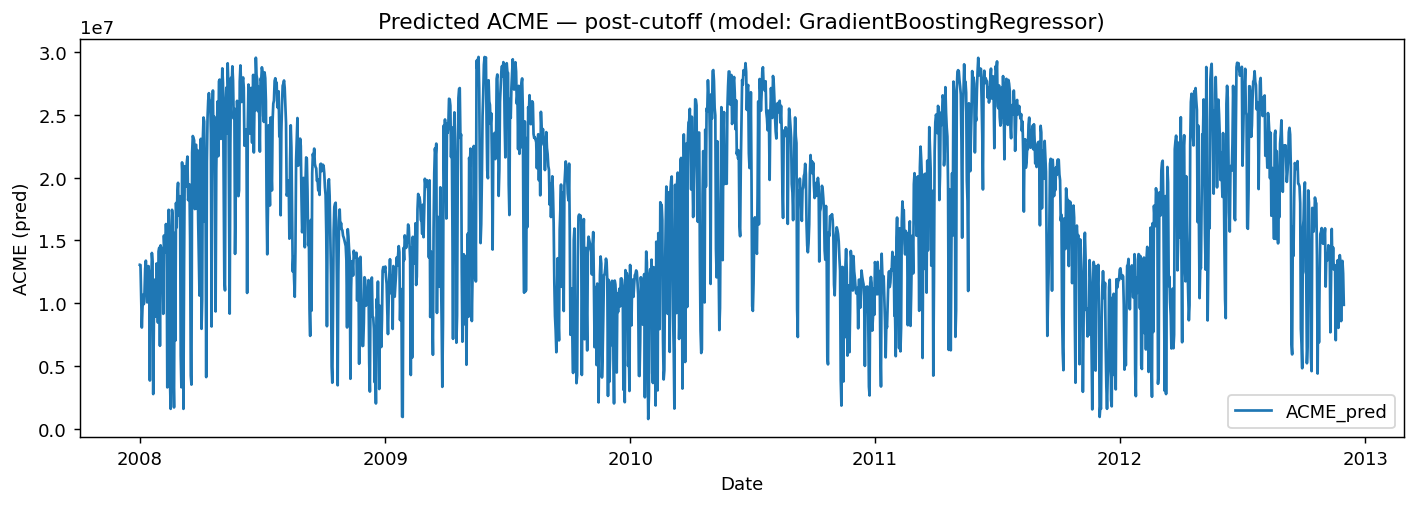

In [39]:
# Predict post-cutoff with the SAME fitted pipeline (prep + model)

# Preconditions
assert 'df'         in globals(), "Provide your full DataFrame 'df'."
assert 'target'     in globals(), "Define 'target' as your target column name."
assert 'cutoff'     in globals(), "Define 'cutoff' (Timestamp or parseable str)."
assert 'features'   in globals(), "Provide the exact training feature list 'features'."
assert 'num_cols'   in globals() and 'cat_cols' in globals(), "num_cols/cat_cols from training are required."
assert 'best_model' in globals(), "Train your model first to get 'best_model'."
assert 'Date'       in df.columns, "'Date' column is required."

# Normalize cutoff and ensure Date dtype
cutoff = pd.Timestamp(cutoff)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Identify future (post-cutoff) rows
post_rows = df['Date'] > cutoff
if not post_rows.any():
    raise ValueError("No rows found after cutoff; adjust 'cutoff' or check your data.")

# Build future block (Date + features [+ target if present])
base_cols = ['Date'] + features + ([target] if target in df.columns else [])
future_df = df.loc[post_rows, base_cols].copy()

print("Future period rows:", future_df.shape[0])
print("Future date range:", future_df['Date'].min(), "→", future_df['Date'].max())

# Diagnostics for the future window (by training features)
avail = future_df[features].notna().mean().sort_values(ascending=False)
print("\nTop-20 future feature coverage:")
print((avail.head(20)*100).round(1).astype(str) + "%")

# Prepare X_future with correct dtypes to match training schema
X_future = future_df[features].copy()

for c in num_cols:
    if c in X_future.columns:
        X_future[c] = pd.to_numeric(X_future[c], errors="coerce")

for c in cat_cols:
    if c in X_future.columns:
        X_future[c] = X_future[c].astype("object")

# Predict with the fitted pipeline (handles impute/scale/OHE internally)
y_future_pred = best_model.predict(X_future)

# Store predictions back in df and create a filled series
pred_col = f"{target}_pred"
df.loc[post_rows, pred_col] = y_future_pred

filled_col = f"{target}_filled"
filled = df[target].copy()
filled.loc[post_rows] = df.loc[post_rows, pred_col]
df[filled_col] = filled

print("\nFuture rows predicted:", int(post_rows.sum()))
print(f"Columns written: '{pred_col}', '{filled_col}'")

# Plot predicted series in the future window
plt.figure(figsize=(11,4))
plt.plot(df.loc[post_rows, 'Date'], df.loc[post_rows, pred_col],
         label=pred_col, linewidth=1.5)
plt.title(f"Predicted {target} — post-cutoff "
          f"(model: {type(best_model.named_steps['model']).__name__})")
plt.xlabel("Date"); plt.ylabel(f"{target} (pred)"); plt.legend(); plt.tight_layout(); plt.show()

# export future predictions to CSV
out = df.loc[post_rows, ['Date', pred_col]].sort_values('Date').reset_index(drop=True)


In [40]:
# Final fit is already done by RandomizedSearchCV (best_model is refit on full train).
# We just align the future matrix to the training features and predict 2008+. 
# Preconditions
assert 'df' in globals() and 'Date' in df.columns
assert 'cutoff' in globals()
assert 'target' in globals()
assert 'features' in globals(), "Provide the exact training feature list used to fit the pipeline."
assert 'best_model' in globals(), "Run the search first so best_model exists."
assert 'num_cols' in globals() and 'cat_cols' in globals()

# Future window (post-cutoff)
future_mask   = df['Date'] > pd.Timestamp(cutoff)
dates_future  = pd.to_datetime(df.loc[future_mask, 'Date'], errors='coerce')

if not future_mask.any():
    raise ValueError("No rows after cutoff to predict.")

# Respect an existing X_future if you built one; otherwise derive from 'features'
if 'X_future' in locals():
    X_future_use = X_future.copy()
    # Ensure it has exactly the training features (add missing as NaN, drop extras)
    X_future_use = X_future_use.reindex(columns=features)
else:
    X_future_use = df.loc[future_mask, features].copy()

# Coerce dtypes to match training schema
for c in num_cols:
    if c in X_future_use.columns:
        X_future_use[c] = pd.to_numeric(X_future_use[c], errors="coerce")
for c in cat_cols:
    if c in X_future_use.columns:
        X_future_use[c] = X_future_use[c].astype("object")

# Predict with the fitted pipeline (prep + model)
y_future_pred = best_model.predict(X_future_use)

# non-negativity clamp (keep if your target cannot be negative)
y_future_pred = np.maximum(y_future_pred, 0.0)

# Build and save output adding all the stations in constant for the Kaggel score
pred_2008_on = pd.DataFrame({
    "Date": dates_future.values,
    target: y_future_pred
}).sort_values("Date")

pred_2008_on['Date'] = pd.to_datetime(pred_2008_on['Date'], errors='coerce')
pred_2008_on['Date'] = pred_2008_on['Date'].dt.strftime('%Y%m%d').astype('int32')

stations = [
    "ADAX","ALTU","APAC","ARNE","BEAV","BESS","BIXB","BLAC","BOIS","BOWL","BREC","BRIS",
    "BUFF","BURB","BURN","BUTL","BYAR","CAMA","CENT","CHAN","CHER","CHEY","CHIC","CLAY",
    "CLOU","COOK","COPA","DURA","ELRE","ERIC","EUFA","FAIR","FORA","FREE","FTCB","GOOD",
    "GUTH","HASK","HINT","HOBA","HOLL","HOOK","HUGO","IDAB","JAYX","KENT","KETC","LAHO",
    "LANE","MADI","MANG","MARE","MAYR","MCAL","MEDF","MEDI","MIAM","MINC","MTHE","NEWK",
    "NINN","NOWA","OILT","OKEM","OKMU","PAUL","PAWN","PERK","PRYO","PUTN","REDR","RETR",
    "RING","SALL","SEIL","SHAW","SKIA","SLAP","SPEN","STIG","STIL","STUA","SULP","TAHL",
    "TALI","TIPT","TISH","VINI","WASH","WATO","WAUR","WEAT","WEST","WILB","WIST","WOOD","WYNO"
]

for var in stations:
    pred_2008_on[var] = 0

out_csv = "/Users/rociofaena/Documents/Machine Learning I/workgroup_project/ACME_2008_onwards_group2.csv"
pred_2008_on.to_csv(out_csv, index=False)
print("Saved predictions to:", out_csv)
print("Rows saved:", len(pred_2008_on))
print("Date range:", pred_2008_on['Date'].min(), "→", pred_2008_on['Date'].max())


Saved predictions to: /Users/rociofaena/Documents/Machine Learning I/workgroup_project/ACME_2008_onwards_group2.csv
Rows saved: 1796
Date range: 20080101 → 20121130
